# Problem 3


In this part, our mission is to apply Markov Random Fields to denoising a picture and improve the performance of denosing.

First, we need to import several package we need to use during this process.

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imtool
from scipy.signal import convolve2d as conv2d
import PIL 
from PIL import Image

Change picture to gray scale picture and the gray value should be shrink between -1 to 1, which will be easy for process later.

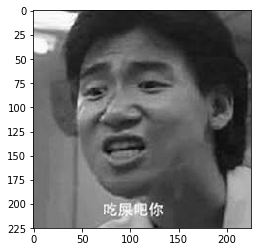

In [10]:
im = Image.open('shishia.png','r')
imm = im.convert('L')
image = np.array(imm)
image = image.astype(np.uint8)
plt.imshow(image, cmap = 'gray')
image = image / 255 * 2 - 1

Create function to add noise on the picture

In [14]:
def addnoise(imorg, nratio=0.1):
    imnsy = imorg.copy()
    # convert '0' to '-1'
    imnsy[imnsy == 0] = -1
    # create random value to indicate flipping pixels
    index = np.random.rand(*imnsy.shape)
    # flip pixels to generate noisy image
    imnsy[index < nratio] *= -1
    
    return imnsy

Display pictures on two colunm:

In [12]:
def showimgs(*args, ncol=2):
    if not args:
        return
    # initialize figure with specific size
    plt.figure(figsize=(16, 10))
    # compose subplot index
    nrow = np.ceil(len(args) / ncol)
    subindex = nrow * 100 + ncol * 10
    # draw each image in subplot
    for i, img in enumerate(args):
        plt.subplot(subindex + i + 1)
        plt.imshow(img, cmap='gray')

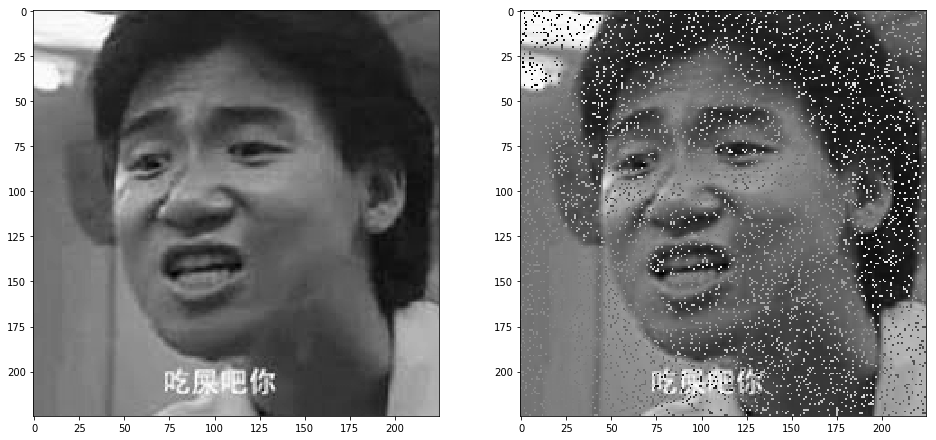

In [15]:
imnsy = addnoise(imorg, nratio = 0.1)
showimgs(image, imnsy)

Apply Markov random field to denoise the picture above:

In [16]:
def denoise(imnsy, efunc, showproc = False):
    # initialize recoverred image as noisy image
    imrec = imnsy.copy()
    # show noisy image
    if showproc:
        plt.imshow(imrec, cmap='gray')
        plt.title('Noisy Image')
        plt.show()
    # calculate energy function and its gradients
    E, dE = efunc(imrec, imnsy)
    # initialize temporal energy and iteration count
    Etmp, i = E + 1, 0
    # optimize energy function through iteration
    while Etmp > E:
        Etmp = E
        # update image by flipping all pixels, which could decrease energy function
        imrec[dE < 0] *= -1
        # calculate energy function with revised image
        [E, dE] = efunc(imrec, imnsy)
        # update iteration count
        i += 1
        # show revised image
        if showproc:
            plt.imshow(imrec, cmap='gray')
            plt.title('Recovered Image (Iter-%d)' % i)
            plt.show()
    # map '-1' to 0 in recovered image
    imrec[imrec == -1] = 0
    # return recovered image
    return imrec

In [17]:
def defaultEnergyFunction(hidden, observation, alpha = 1, beta = 1, eta = 1):
    # create filter for beta term
    Tb = np.asarray([[0, 1.0, 0], [1.0, 0, 1.0], [0, 1.0, 0]])
    # convolve hidden image with term B's filter
    matB = conv2d(hidden, Tb, 'same')
    # calculate energy map
    mapE = hidden * (alpha - beta * matB - eta * observation)
    # get mean of matrix as energy
    E = np.mean(mapE)
    # calculate energy difference map
    dE = -2 * mapE
    
    return E, dE

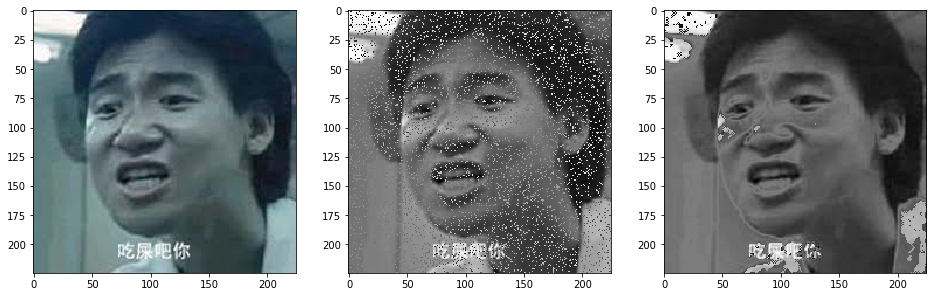

In [18]:
imrec = denoise(imnsy, defaultEnergyFunction)
showimgs(imorg, imnsy, imrec, ncol = 3)

After first denosing, we can see the result is not goood enough. The denosing process need to be improved.

Using median filter mentioned in demo to make a improvement.

In [19]:
medFilter = lambda hidden, observation: defaultEnergyFunction(hidden, observation,
                                                              alpha=0, beta=1, eta=0)

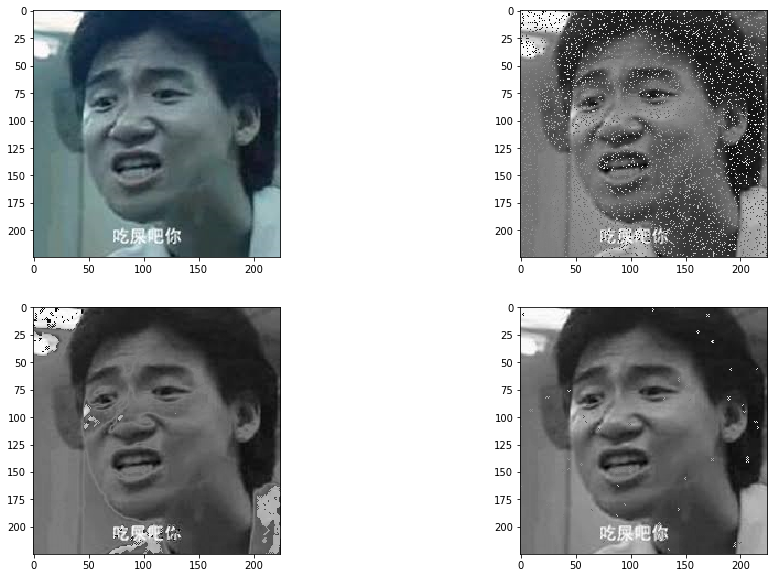

In [20]:
imrecMed = denoise(imnsy, medFilter)
showimgs(imorg, imnsy, imrec, imrecMed)

As we can see the fourth picture is obviously better than third.